### *Начало пути. Импорт библиотек и данных.*

In [1]:
import warnings
warnings.filterwarnings(action='ignore', category=DeprecationWarning)
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.feature_selection import chi2, RFE, VarianceThreshold, SelectFromModel
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import cross_validate
from sklearn.ensemble import VotingClassifier

C:\Users\knigo\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [2]:
in_df = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
gender = pd.read_csv('gender_submission.csv')

***
*Просмотр данных.*
***

In [3]:
in_df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [4]:
test.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


In [5]:
in_df.isna().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

***
*Понемногу будем убирать ненужные. Кабину (каюту) очевидно можно убрать, ближе к концу будет строчка дропа. Возраст заменим по нормальному распределению, а порт отправления пассажира оценим исходя из величины оплаты.*
***

In [6]:
in_df.shape, test.shape

((891, 12), (418, 11))

In [7]:
df = pd.concat((in_df, test), sort = True, ignore_index=True)
df.loc[df.Embarked.isna()]

,Age,Cabin,Embarked,Fare,Name,Parch,PassengerId,Pclass,Sex,SibSp,Survived,Ticket
61,38.0,B28,NaN,80.0,"Icard, Miss. Amelie",0,62,1,female,0,1.0,113572
829,62.0,B28,NaN,80.0,"Stone, Mrs. George Nelson (Martha Evelyn)",0,830,1,female,0,1.0,113572


In [8]:
df.shape

(1309, 12)

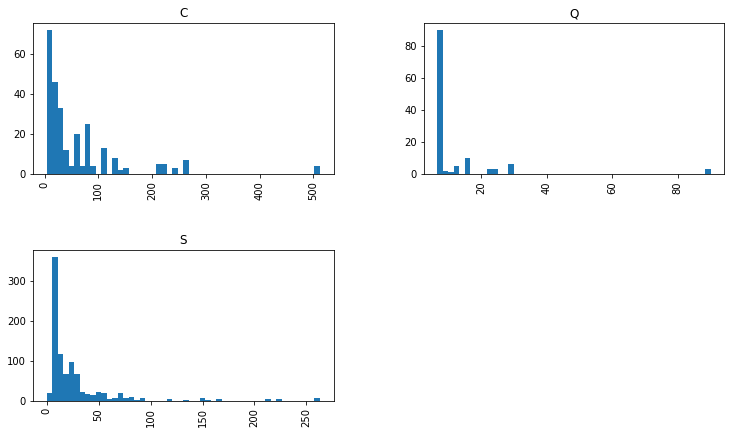

In [9]:
hist = df.hist(column = 'Fare', by = 'Embarked', grid=True, figsize = (12, 7), bins = 50)

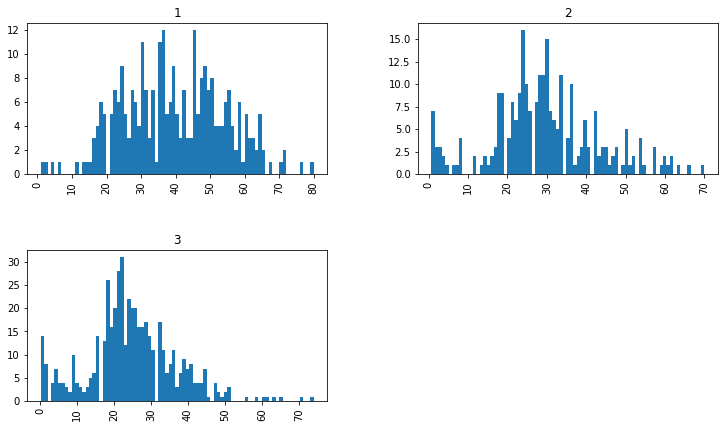

In [10]:
df.loc[df.Embarked.isna(), 'Embarked'] = 'C'
n_bins = int(df.Age.max()-df.Age.min())
hist = df.hist(column = 'Age', by = 'Pclass', grid=True, figsize = (12, 7), bins = n_bins)

***
*Видно, что 80 отдали либо в S, либо в C. Предположим, что это C, так как там значений около 80 больше.  
У единственного пассажира без оплаты в графе Fare ставим среднее значение по всем, у кого такой же класс и порт отправления.  
Теперь к возрасту. Заполним пустые по нормальному распределению (как уже было сказано), которое кажется тут достаточно правдоподобным. Затем выполним агрегирование.*
***

In [11]:
df.isna().sum()

Age             263
Cabin          1014
Embarked          0
Fare              1
Name              0
Parch             0
PassengerId       0
Pclass            0
Sex               0
SibSp             0
Survived        418
Ticket            0
dtype: int64

In [12]:
df.loc[df.Fare.isna()]

,Age,Cabin,Embarked,Fare,Name,Parch,PassengerId,Pclass,Sex,SibSp,Survived,Ticket
1043,60.5,NaN,S,NaN,"Storey, Mr. Thomas",0,1044,3,male,0,NaN,3701


In [13]:
df.loc[df.Fare.isna(), 'Fare'] = df.where((df.Pclass == 3)&(df.Embarked == 'S')).dropna().Age.mean()

In [14]:
age1 = round(df.where(df.Pclass == 1).dropna().Age.mean())
age1_std = round(np.std(df.where(df.Pclass == 1).dropna().Age))
age2 = round(df.where(df.Pclass == 2).dropna().Age.mean())
age2_std = round(np.std(df.where(df.Pclass == 2).dropna().Age))
age3 = round(df.where(df.Pclass == 3).dropna().Age.mean())
age3_std = round(np.std(df.where(df.Pclass == 3).dropna().Age))

for i in range(df.shape[0]):
    if df.Age.isna()[i] == True:
        if df.Pclass[i] == 1:
            df.Age[i] = abs(np.random.normal(age1, age1_std, 1).round().astype(int)[0])
        elif df.Pclass[i] == 2:
            df.Age[i] = abs(np.random.normal(age2, age2_std, 1).round().astype(int)[0])
        else:
            df.Age[i] = abs(np.random.normal(age3, age3_std, 1).round().astype(int)[0])

C:\Users\knigo\Anaconda3\lib\site-packages\ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app
C:\Users\knigo\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  del sys.path[0]
C:\Users\knigo\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # This is added back by InteractiveShellApp.init_path()


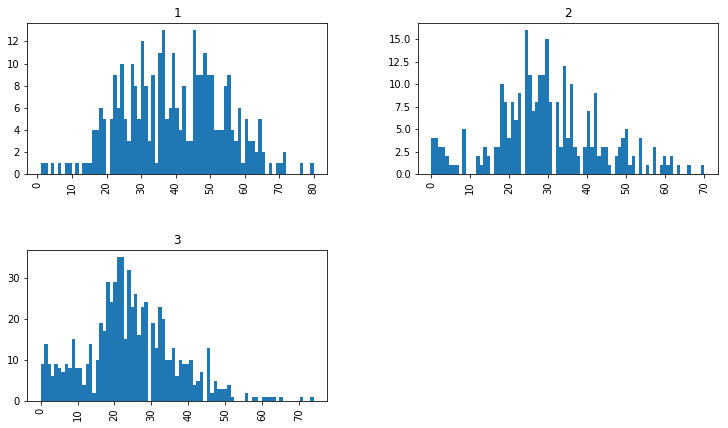

In [15]:
hist = df.hist(column = 'Age', by = 'Pclass', grid=True, figsize = (12, 7), bins = n_bins)

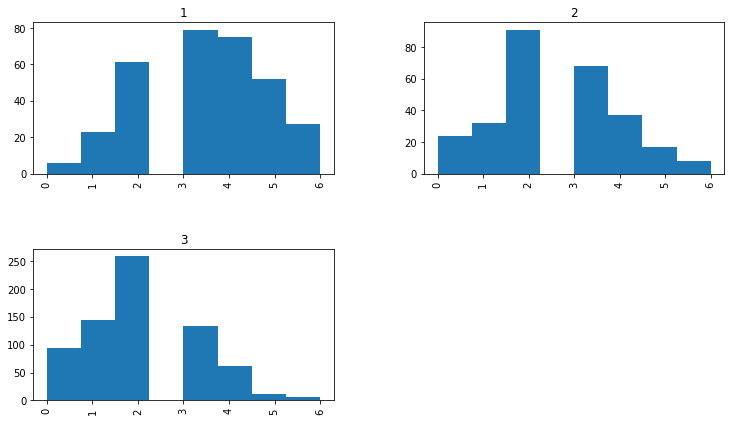

In [16]:
df.Age = df.Age.astype('int')
df.loc[df.Age < 10, 'Age'] = 0
df.loc[(df.Age >= 10)&(df.Age < 20), 'Age'] = 1
df.loc[(df.Age >= 20)&(df.Age < 30), 'Age'] = 2
df.loc[(df.Age >= 30)&(df.Age < 40), 'Age'] = 3
df.loc[(df.Age >= 40)&(df.Age < 50), 'Age'] = 4
df.loc[(df.Age >= 50)&(df.Age < 60), 'Age'] = 5
df.loc[df.Age >= 60, 'Age'] = 6
hist = df.hist(column = 'Age', by = 'Pclass', figsize = (12, 7), bins = 8)

***
*Аналогично поступаем с платой за билет, а именно агрегируем. Выбраны такие промежутки, чтобы для каждой из трёх групп (Pclass и Embarked) имелось достаточное количество промежутков. Также одной строкой переопределяю пол на 0 и 1 для мужского и женского соответственно, а порт меняю с букв на цифры.*
***

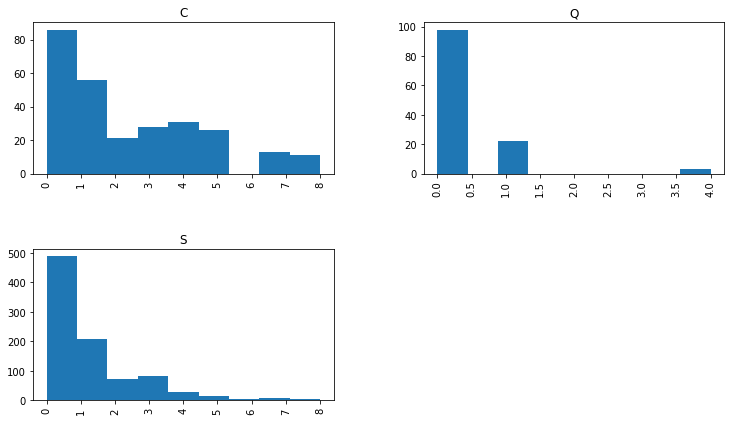

In [17]:
# Аналогично по Fare
df.loc[df.Fare < 15, 'Fare'] = 0
df.loc[(df.Fare >= 15)&(df.Fare < 30), 'Fare'] = 1
df.loc[(df.Fare >= 30)&(df.Fare < 45), 'Fare'] = 2
df.loc[(df.Fare >= 45)&(df.Fare < 75), 'Fare'] = 3
df.loc[(df.Fare >= 75)&(df.Fare < 105), 'Fare'] = 4
df.loc[(df.Fare >= 105)&(df.Fare < 155), 'Fare'] = 5
df.loc[(df.Fare >= 155)&(df.Fare < 205), 'Fare'] = 6
df.loc[(df.Fare >= 205)&(df.Fare < 255), 'Fare'] = 7
df.loc[df.Fare >= 255, 'Fare'] = 8
df.Fare = df.Fare.astype('int')
hist = df.hist(column = 'Fare', by = 'Embarked', grid=True, figsize = (12, 7), bins = 9)

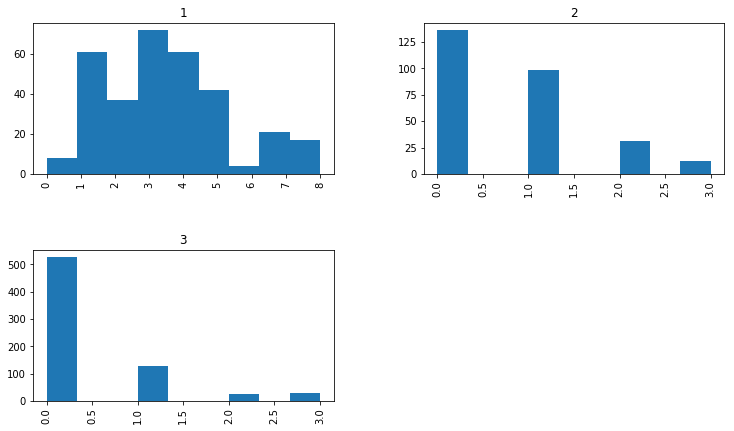

In [18]:
hist = df.hist(column = 'Fare', by = 'Pclass', grid=True, figsize = (12, 7), bins = 9)

In [19]:
df = df.drop(columns = 'Cabin')
df.Sex.replace({'male': 0, 'female': 1}, inplace = True)
df.Embarked.replace({'C': 0, 'S': 1, 'Q': 2}, inplace = True)

In [20]:
# Пустых колонок нет.
df.drop(columns = 'Survived').isna().sum() == 0

Age            True
Embarked       True
Fare           True
Name           True
Parch          True
PassengerId    True
Pclass         True
Sex            True
SibSp          True
Ticket         True
dtype: bool

In [21]:
df.loc[(df.SibSp == 0)&(df.Parch == 0), 'Alone'] = 1
df.loc[(df.SibSp != 0)|(df.Parch != 0), 'Alone'] = 0
df['Family'] = df.SibSp + df.Parch

***
*Конечный взгляд на полученный датасет. Данные по SibSp и Parch переделаны в Alone и Family.*
***

In [22]:
df.head()

,Age,Embarked,Fare,Name,Parch,PassengerId,Pclass,Sex,SibSp,Survived,Ticket,Alone,Family
0,2,1,0,"Braund, Mr. Owen Harris",0,1,3,0,1,0.0,A/5 21171,0.0,1
1,3,0,3,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,2,1,1,1,1.0,PC 17599,0.0,1
2,2,1,0,"Heikkinen, Miss. Laina",0,3,3,1,0,1.0,STON/O2. 3101282,1.0,0
3,3,1,3,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,4,1,1,1,1.0,113803,0.0,1
4,3,1,0,"Allen, Mr. William Henry",0,5,3,0,0,0.0,373450,1.0,0


In [23]:
df.shape

(1309, 13)

In [24]:
test.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


***
*Разделяем датасеты обратно.*
***

In [25]:
test1 = df[-test.shape[0]:]
train1 = df[:in_df.shape[0]]
X_train = train1.drop(columns = ['Survived', 'Name', 'Ticket', 'PassengerId', 'SibSp', 'Parch'])
y_train = train1.Survived
X_test = test1.drop(columns = ['Survived','Name', 'Ticket', 'PassengerId', 'SibSp', 'Parch'])

In [26]:
df

,Age,Embarked,Fare,Name,Parch,PassengerId,Pclass,Sex,SibSp,Survived,Ticket,Alone,Family
0,2,1,0,"Braund, Mr. Owen Harris",0,1,3,0,1,0.0,A/5 21171,0.0,1
1,3,0,3,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,2,1,1,1,1.0,PC 17599,0.0,1
2,2,1,0,"Heikkinen, Miss. Laina",0,3,3,1,0,1.0,STON/O2. 3101282,1.0,0
3,3,1,3,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,4,1,1,1,1.0,113803,0.0,1
4,3,1,0,"Allen, Mr. William Henry",0,5,3,0,0,0.0,373450,1.0,0
5,1,2,0,"Moran, Mr. James",0,6,3,0,0,0.0,330877,1.0,0
6,5,1,3,"McCarthy, Mr. Timothy J",0,7,1,0,0,0.0,17463,1.0,0
7,0,1,1,"Palsson, Master. Gosta Leonard",1,8,3,0,3,0.0,349909,0.0,4
8,2,1,0,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)",2,9,3,1,0,1.0,347742,0.0,2
9,1,0,2,"Nasser, Mrs. Nicholas (Adele Achem)",0,10,2,1,1,1.0,237736,0.0,1


In [27]:
X_train.head()

,Age,Embarked,Fare,Pclass,Sex,Alone,Family
0,2,1,0,3,0,0.0,1
1,3,0,3,1,1,0.0,1
2,2,1,0,3,1,1.0,0
3,3,1,3,1,1,0.0,1
4,3,1,0,3,0,1.0,0


In [28]:
selector = SelectFromModel(estimator=LogisticRegression()).fit(X_train, y_train)
selector.estimator_.coef_

array([[-0.22459055, -0.09182246,  0.16544568, -0.76728157,  2.59759412,
        -0.57662512, -0.38469592]])

In [29]:
selector.threshold_

0.6868650596910805

In [30]:
clf = RandomForestClassifier(n_estimators=10000, random_state=0, n_jobs=-1)
sfm = SelectFromModel(clf).fit(X_train, y_train)
feat_labels = X_train.columns
for feature_list_index in sfm.get_support(indices=True):
    print(feat_labels[feature_list_index])

Age
Sex


In [31]:
rfc = RandomForestClassifier(random_state=1)
knn = KNeighborsClassifier()
lgr = LogisticRegression()
xgb = XGBClassifier()
gbc = GradientBoostingClassifier()
svc = SVC(probability=True)
gnb = GaussianNB()

models = [rfc, knn, lgr, xgb, gbc, svc, gnb]         
scores = []

for mod in models:
    mod.fit(X_train, y_train)
    acc = cross_val_score(mod, X_train, y_train, scoring = "accuracy", cv = 20)
    scores.append(acc.mean())

C:\Users\knigo\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\Users\knigo\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\Users\knigo\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\Users\knigo\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but i

In [32]:
results = pd.DataFrame({
    'Model': ['Random Forest', 'K Nearest Neighbour', 'Logistic Regression', 'XGBoost', 'Gradient Boosting', 'SVC', 'Gaussian Naive Bayes'],
    'Score': scores})

result_df = results.sort_values(by='Score', ascending=False).reset_index(drop=True)
result_df.head()

,Model,Score
0,SVC,0.820385
1,Gradient Boosting,0.804774
2,XGBoost,0.803662
3,Logistic Regression,0.795884
4,Random Forest,0.795735


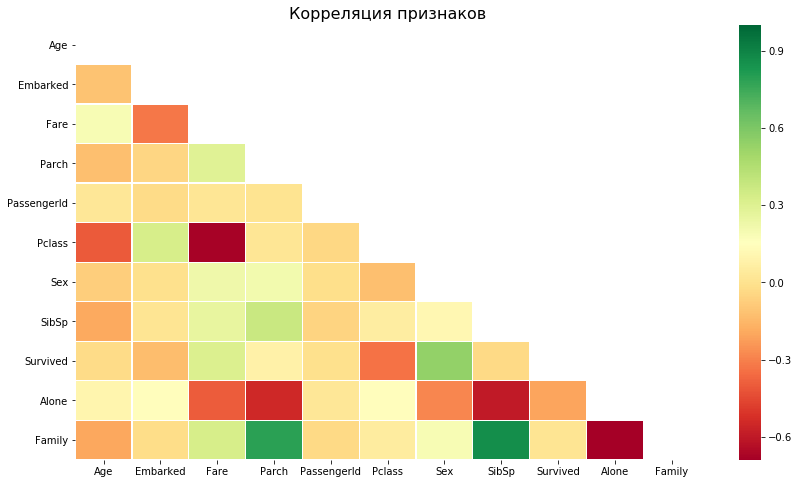

In [33]:
corr = df.corr()
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
plt.figure(figsize=(14, 8))
plt.title('Корреляция признаков', fontsize=16)
sns.heatmap(corr, mask=mask, annot=False,cmap='RdYlGn', linewidths=0.2, annot_kws={'size':20})
plt.show()

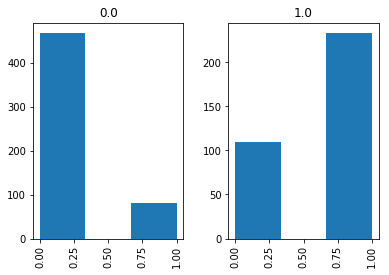

In [34]:
hist = df.hist(column = 'Sex', by = 'Survived', bins = 3)

In [35]:
choose_alg = VotingClassifier(estimators = [('Random Forest', rfc), 
                                           ('Logistic Regression', lgr),
                                           ('XGBoost', xgb),
                                           ('Gradient Boosting', gbc),
                                           ('SVC', svc),
                                           ('K Nearest Neighbour', knn)], voting = 'soft')

choose_alg_cv = cross_validate(choose_alg, X_train, y_train, cv = 20)
choose_alg.fit(X_train, y_train)

print("Soft voting on test set score mean: {:.2f}". format(choose_alg_cv['test_score'].mean()*100))

C:\Users\knigo\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\Users\knigo\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\Users\knigo\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\Users\knigo\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but i

C:\Users\knigo\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\Users\knigo\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\Users\knigo\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\Users\knigo\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but i

Soft voting on test set score mean: 81.48


C:\Users\knigo\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


In [39]:
test.isna().sum()

PassengerId      0
Pclass           0
Name             0
Sex              0
Age             86
SibSp            0
Parch            0
Ticket           0
Fare             1
Cabin          327
Embarked         0
dtype: int64

In [43]:
passId = test['PassengerId']
predictions = choose_alg.predict(X_test)

submission = pd.concat([pd.DataFrame(passId), pd.DataFrame(predictions).astype('int')], axis = 'columns')

submission.columns = ["PassengerId", "Survived"]
submission.to_csv('titanic_submission.csv', header = True, index = False)

C:\Users\knigo\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
